# Linear Discriminant Analysis in Python

From: https://towardsdatascience.com/linear-discriminant-analysis-in-python-76b8b17817c2

Verwendet das Wine-Datenset

Linear Discriminant Analysis (LDA) is a dimensionality reduction technique. As the name implies dimensionality reduction techniques reduce the number of dimensions (i.e. variables) in a dataset while retaining as much information as possible. For instance, suppose that we plotted the relationship between two variables where each color represent a different class.

<img src="Py_LDA_Example_Fig1.PNG">

If we’d like to reduce the number of dimensions down to 1, one approach would be to project everything on to the x-axis.

<img src="Py_LDA_Example_Fig2.png">

<img src="Py_LDA_Example_Fig3.png">

This is bad because it disregards any useful information provided by the second feature. On the other hand, Linear Discriminant Analysis, or LDA, uses the information from both features to create a new axis and projects the data on to the new axis in such a way as to minimizes the variance and maximizes the distance between the means of the two classes.


<img src="Py_LDA_Example_Fig4.png">

<img src="Py_LDA_Example_Fig5.png">

<img src="Py_LDA_Example_Fig6.png">

## Code

In [1]:
from matplotlib import pyplot as plt

import numpy as np
np.set_printoptions(precision=4)

import pandas as pd

import seaborn as sns
sns.set()

from sklearn.datasets import load_wine
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
wine = load_wine()
X = pd.DataFrame(wine.data, columns=wine.feature_names)
y = pd.Categorical.from_codes(wine.target, wine.target_names)

In [6]:
df = X.join(pd.Series(y, name='class'))

In [7]:
df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,class_0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,class_0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,class_0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,class_0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,class_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,class_2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,class_2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,class_2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,class_2


## LDA steps

LDA can be broken up into the following steps:
1. Compute the within class and between class scatter matrices
1. Compute the eigenvectors and corresponding eigenvalues for the scatter matrices
1. Sort the eigenvalues and select the top k
1. Create a new matrix containing eigenvectors that map to the k eigenvalues
1. Obtain the new features (i.e. LDA components) by taking the dot product of the data and the matrix from step 4

## Within Class Scatter Matrix
We calculate the *within class scatter matrix* using the following formula:

\begin{equation}
S_W = \sum_{i=1}^{c} S_i
\end{equation}

where $c$ is the total number of distinct classes and 

\begin{equation}
S_i = \sum_{\mathbf{x} \in D_i}^{n} (\mathbf{x} - \mathbf{m}_i)(\mathbf{x} - \mathbf{m}_i)^T
\end{equation}

and

\begin{equation}
\mathbf{m}_i = \frac{1}{n_i} \sum_{\mathbf{x} \in D_i}^{n} \mathbf{x}_k
\end{equation}
where $\mathbf{x}$ is a sample (i.e. row) and $n$ is the total number of samples with a given class.
For every class, we create a vector with the means of each feature.


In [8]:
class_feature_means = pd.DataFrame(columns=wine.target_names)
for c, rows in df.groupby('class'):
    class_feature_means[c] = rows.mean()
class_feature_means

,class_0,class_1,class_2
alcohol,13.744746,12.278732,13.153750
malic_acid,2.010678,1.932676,3.333750
ash,2.455593,2.244789,2.437083
alcalinity_of_ash,17.037288,20.238028,21.416667
magnesium,106.338983,94.549296,99.312500
total_phenols,2.840169,2.258873,1.678750
flavanoids,2.982373,2.080845,0.781458
nonflavanoid_phenols,0.290000,0.363662,0.447500
proanthocyanins,1.899322,1.630282,1.153542
color_intensity,5.528305,3.086620,7.396250


Then, we plug the mean vectors ($\mathbf{m}_i$) into the equation from before in order to obtain the within class scatter matrix.

In [17]:
within_class_scatter_matrix = np.zeros((13,13))
for c, rows in df.groupby('class'):
    rows = rows.drop(['class'], axis=1)
    s = np.zeros((13,13))

for index, row in rows.iterrows():
    x, mc = row.values.reshape(13,1), class_feature_means[c].values.reshape(13,1)
    s += (x - mc).dot((x - mc).T)
    within_class_scatter_matrix += s

## Between Class Scatter Matrix

Next, we calculate the between class scatter matrix using the following formula:

\begin{equation}
S_B = \sum_{i=1}^{c} N_i(\mathbf{m}_i - \mathbf{m})(\mathbf{m}_i - \mathbf{m})^T
\end{equation}

where 

\begin{equation}
\mathbf{m}_i = \frac{1}{n_i} \sum_{\mathbf{x} \in D_i}^{n} \mathbf{x}_k
\end{equation}

\begin{equation}
\mathbf{m} = \frac{1}{n} \sum_{i=1}^{n} \mathbf{x}_i
\end{equation}

In [18]:
feature_means = df.mean()
between_class_scatter_matrix = np.zeros((13,13))
for c in class_feature_means:    
    n = len(df.loc[df['class'] == c].index)
    
    mc, m = class_feature_means[c].values.reshape(13,1), feature_means.values.reshape(13,1)
    
    between_class_scatter_matrix += n * (mc - m).dot((mc - m).T)

Then, we solve the generalized eigenvalue problem for

\begin{equation}
S_W^{-1}S_B
\end{equation}

to obtain the linear discriminants.

In [19]:
eigen_values, eigen_vectors = np.linalg.eig(np.linalg.inv(within_class_scatter_matrix).dot(between_class_scatter_matrix))

The eigenvectors with the highest eigenvalues carry the most information about the distribution of the data. Thus, we sort the eigenvalues from highest to lowest and select the first $k$ eigenvectors. In order to ensure that the eigenvalue maps to the same eigenvector after sorting, we place them in a temporary array.

In [20]:
pairs = [(np.abs(eigen_values[i]), eigen_vectors[:,i]) for i in range(len(eigen_values))]
pairs = sorted(pairs, key=lambda x: x[0], reverse=True)
for pair in pairs:
    print(pair[0])

9.884546449232964
2.903361061716055
8.328748314463861e-16
8.328748314463861e-16
4.886713002064387e-16
4.489875014453336e-16
3.4635722681863882e-16
3.4635722681863882e-16
1.0056538289828519e-16
7.842049664151311e-17
7.842049664151311e-17
5.900795033178523e-17
0.0


Just looking at the values, it’s difficult to determine how much of the variance is explained by each component. Thus, we express it as a percentage.

In [21]:
eigen_value_sums = sum(eigen_values)
print('Explained Variance')
for i, pair in enumerate(pairs):
    print('Eigenvector {}: {}'.format(i, (pair[0]/eigen_value_sums).real))

Explained Variance
Eigenvector 0: 0.7729604269322252
Eigenvector 1: 0.2270395730677747
Eigenvector 2: 6.51298760749777e-17
Eigenvector 3: 6.51298760749777e-17
Eigenvector 4: 3.821354664850663e-17
Eigenvector 5: 3.511031817057716e-17
Eigenvector 6: 2.7084746001023813e-17
Eigenvector 7: 2.7084746001023813e-17
Eigenvector 8: 7.864099956320532e-18
Eigenvector 9: 6.132394731066783e-18
Eigenvector 10: 6.132394731066783e-18
Eigenvector 11: 4.614355419857593e-18
Eigenvector 12: 0.0


First, we create a matrix $W$ with the first two eigenvectors:

In [23]:
w_matrix = np.hstack((pairs[0][1].reshape(13,1), pairs[1][1].reshape(13,1))).real
w_matrix

array([[-4.1562e-02,  2.0879e-01],
       [-1.6684e-02,  3.6500e-03],
       [-4.4776e-03,  4.5911e-01],
       [ 7.5359e-03, -2.4950e-02],
       [ 6.4335e-03,  3.1071e-03],
       [ 9.7213e-02,  1.9083e-01],
       [-7.2041e-01,  2.6494e-02],
       [-6.5156e-01,  3.4334e-01],
       [ 1.6083e-02, -4.0468e-01],
       [ 2.7091e-02,  6.7012e-03],
       [-1.9634e-02, -5.7682e-01],
       [-2.0866e-01, -3.0567e-01],
       [-5.9173e-04,  9.9706e-04]])

Then, we save the dot product of $X$ and $W$ into a new matrix $Y$.

\begin{equation}
Y = X \cdot W
\end{equation}

where $X$ is a $n\times d$ matrix with $n$ samples and $d$ dimensions, and $Y$ is a $n\times k$ matrix with $n$ samples and $k$ ($k<n$) dimensions. In other words, $Y$ is composed of the LDA components, or said yet another way, the new feature space.

In [28]:
X_lda = np.array(X.dot(w_matrix))

`matplotlib` can’t handle categorical variables directly. Thus, we encode every class as a number so that we can incorporate the class labels into our plot.

In [30]:
le = LabelEncoder()
y = le.fit_transform(df['class'])
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

Then, we plot the data as a function of the two LDA components and use a different color for each class.

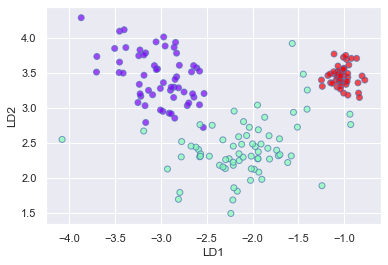

In [32]:
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.scatter(
    X_lda[:,0],
    X_lda[:,1],
    c=y,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
);

Rather than implementing the Linear Discriminant Analysis algorithm from scratch every time, we can use the predefined `LinearDiscriminantAnalysis` class made available to us by the `sklearn` library.

In [33]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X, y)

We can access the following property to obtain the variance explained by each component.

In [34]:
lda.explained_variance_ratio_

array([0.6875, 0.3125])

Just like before, we plot the two LDA components.

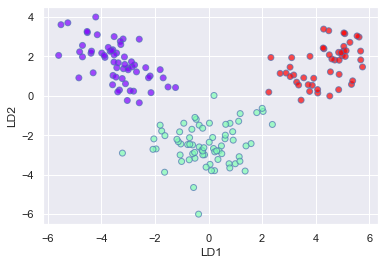

In [35]:
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.scatter(
    X_lda[:,0],
    X_lda[:,1],
    c=y,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
);

Next, let’s take a look at how LDA compares to Principal Component Analysis or PCA. We start off by creating and fitting an instance of the PCA class.

In [36]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X, y)

We can access the `explained_variance_ratio_` property to view the percentage of the variance explained by each component.

In [37]:
pca.explained_variance_ratio_

array([0.9981, 0.0017])

As we can see, PCA selected the components which would result in the highest spread (retain the most information) and not necessarily the ones which maximize the separation between classes.

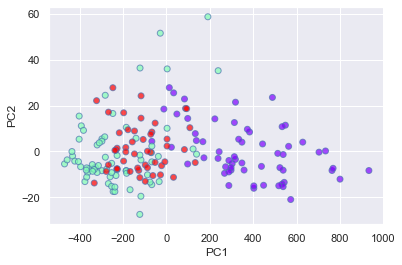

In [38]:
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.scatter(
    X_pca[:,0],
    X_pca[:,1],
    c=y,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
);

Next, let’s see whether we can create a model to classify the using the LDA components as features. First, we split the data into training and testing sets.

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_lda, y, random_state=1)

Then, we build and train a Decision Tree. After predicting the category of each sample in the test set, we create a confusion matrix to evaluate the model’s performance.

In [40]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[18,  0,  0],
       [ 0, 17,  0],
       [ 0,  0, 10]], dtype=int64)

As we can see, the Decision Tree classifier correctly classified everything in the test set.